## Preliminaries

In [1]:
!nvidia-smi

Sun Dec 17 15:58:10 2023       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 530.30.02              Driver Version: 530.30.02    CUDA Version: 12.1     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                  Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf            Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA RTX A4000                On | 00000000:02:00.0 Off |                  Off |
| 41%   37C    P8               14W / 140W|   1752MiB / 16376MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [2]:
%%capture
!pip install torchmetrics
!pip install pandas
!pip install matplotlib
!pip install seaborn
!pip install einops

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms
import torchvision.models as models
import pandas as pd
from matplotlib import pyplot as plt
from torch.utils.data import Dataset
# from PIL import Image
import torch.nn.functional as F
import numpy as np
# import seaborn as sns
# import torchmetrics
from einops.layers.torch import Rearrange
from tqdm.auto import tqdm
import warnings
warnings.filterwarnings('ignore')

torch.manual_seed(0xC0FFEE)

/home/ubuntu/miniconda3/envs/nickl_ViT_quant/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Load Dataset (CIFAR10)

In [12]:
data_root = './data/cifar10'

In [14]:
train_data = torchvision.datasets.CIFAR10(root=data_root,
                                             train=True,
                                             download=False,
                                             transform=transforms.ToTensor())

In [15]:
loader = torch.utils.data.DataLoader(train_data, batch_size=64, shuffle=False, num_workers=1)

In [16]:
mean = 0.
std = 0.
nb_samples = 0.
for data, _ in loader:
    batch_samples = data.size(0)
    data = data.view(batch_samples, data.size(1), -1)
    mean += data.mean(2).sum(0)
    std += data.std(2).sum(0)
    nb_samples += batch_samples

mean /= nb_samples
std /= nb_samples

In [17]:
print(mean)
print(std)

tensor([0.4914, 0.4822, 0.4465])
tensor([0.2023, 0.1994, 0.2010])


## Define Data Transforms & Augmentations

In [18]:
from torchvision.transforms.functional import rotate

train_transform = transforms.Compose([transforms.ToTensor(),
                                      transforms.Resize((224, 224)),
                                      transforms.Normalize(mean, std),
                                      transforms.RandomHorizontalFlip(),
                                      transforms.RandomAffine(degrees=45, translate=(0.3, 0.3)),
                                      ])

test_transform = transforms.Compose([transforms.ToTensor(),
                                     transforms.Resize((224, 224)),
                                     transforms.Normalize(mean, std)])

## Create Train, Val and Test Dataloaders

In [21]:
train_data = torchvision.datasets.CIFAR10(root=data_root,
                                           train=True,
                                           download=False,
                                           transform=train_transform)

val_data = torchvision.datasets.CIFAR10(root=data_root,
                                         train=True,
                                         download=False,
                                         transform=test_transform)

val_count = round(len(train_data) * 0.05)
train_count = len(train_data) - val_count

train_data, _ = torch.utils.data.random_split(train_data, [train_count, val_count])
_, val_data = torch.utils.data.random_split(val_data, [train_count, val_count])

test_data = torchvision.datasets.CIFAR10(root=data_root,
                                          train=False,
                                          download=False,
                                          transform=test_transform)

classes = train_data.dataset.classes

print(f'Train: {len(train_data)}, Val: {len(val_data)}, Test: {len(test_data)}')

Train: 47500, Val: 2500, Test: 10000


In [22]:
batch_size = 512

train_dataloader = torch.utils.data.DataLoader(train_data,
                                               batch_size=batch_size,
                                               shuffle=True,
                                               num_workers=1,
                                               pin_memory=True)

val_dataloader = torch.utils.data.DataLoader(val_data,
                                             batch_size=batch_size,
                                             shuffle=False,
                                             num_workers=1)

test_dataloader = torch.utils.data.DataLoader(test_data,
                                              batch_size=batch_size,
                                              shuffle=False,
                                              num_workers=1)

## Display Sample Images

In [23]:
def show_img(img):
    img = (mean.view(-1,1,1) + img * std.view(-1,1,1))
    plt.imshow(np.transpose(img.numpy(), (1, 2, 0)))

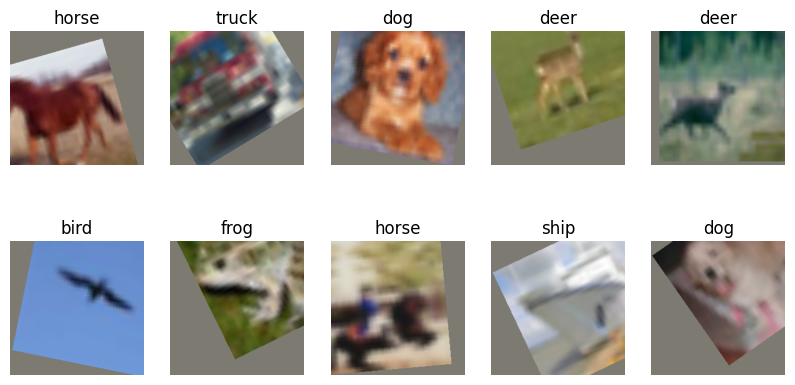

In [24]:
images, labels = next(iter(train_dataloader))
plt.figure(figsize=(10,5))
for i in range(10):
    plt.subplot(2, 5, i+1)
    show_img(images[i])
    plt.title(f'{classes[labels[i]]}')
    plt.axis('off')

# Pretrained Model

In [25]:
class PretrainedVit(nn.Module):
    
    def __init__(self, num_classes):
        super().__init__()
        self.vit = models.vit_b_32(weights  = models.ViT_B_32_Weights)
        self.freeze_weights()
        self.vit.heads = nn.Linear(self.vit.hidden_dim, num_classes)
    
    def freeze_weights(self):
        for p in self.vit.parameters():
            p = p.requires_grad_(False)
            
    def forward(self, x):
        return self.vit(x)

# Custom Model

In [26]:
class MHA(nn.Module):
    
    def __init__(self, d_model, n_heads, dropout):
        super().__init__()
        self.d_model = d_model
        self.n_heads = n_heads
        self.d_head = d_model // n_heads
        
        self.Q = nn.Linear(d_model, d_model)
        self.K = nn.Linear(d_model, d_model)
        self.V = nn.Linear(d_model, d_model)

        self.Out = nn.Linear(d_model , d_model)
        
        self.scale = self.d_head ** -0.5
        self.drop = nn.Dropout(dropout)
        
    def forward(self, x):
        B, S, C = x.shape
        q = self.Q(x).view(B, S, self.n_heads, self.d_head).transpose(1,2)
        k = self.K(x).view(B, S, self.n_heads, self.d_head).transpose(1,2)
        v = self.V(x).view(B, S, self.n_heads, self.d_head).transpose(1,2)
        
        qk = (q @ k.transpose(-2, -1)) * self.scale
        
        att = F.softmax(qk, dim=-1)
        self.att_weights = att
        
        att_v = att @ v
        
        out = self.drop(self.Out(att_v.transpose(1,2).contiguous().view(B, S, C)))
        
        return out, att

In [27]:
class EncoderLayer(nn.Module):

    def __init__(self, d_model, num_heads, mul = 4 ,dropout = 0.1):

        super().__init__()

        self.sa = MHA(d_model, num_heads, dropout)

        self.ffn = nn.Sequential(
            nn.Linear(d_model, d_model * mul),
            nn.GELU(),
            nn.Linear(mul * d_model, d_model)
        )

        self.ln1 = nn.LayerNorm(d_model)
        self.ln2 = nn.LayerNorm(d_model)

    def forward(self, x):
        x, att = self.sa(x)
        self.att = att
        x = x + self.ln1(x)
        x = x + self.ln2(self.ffn(x))

        return x

In [28]:
class ViTEncoder(nn.Module):

    def __init__(self, in_ch, d_model, num_heads, n_blocks, num_classes = 100, mul = 4,patch_size = 16, img_size = 224):

        
        super().__init__()

        
        self.lp_src = nn.Sequential(
            Rearrange('b c (h p1) (w p2) -> b (h w) (p1 p2 c)', p1 = patch_size, p2 = patch_size),
            nn.LayerNorm(patch_size**2 * in_ch),
            nn.Linear(patch_size**2* in_ch, d_model),
            nn.LayerNorm(d_model),
        ) 

        self.cls = nn.Parameter(torch.randn(1,1,d_model))
        
        self.to_cls_token = nn.Identity()
        self.pos = nn.Parameter(torch.randn(1, (img_size // patch_size)**2 + 1, d_model))


        self.blocks = nn.Sequential(
            *[EncoderLayer(d_model, num_heads, mul) for _ in range(n_blocks)]
        )

        self.cl = nn.Linear(d_model, num_classes)

    def forward(self, x):
        cls_token = self.cls.expand(x.shape[0], -1, -1)
        x = self.lp_src(x)

        x = torch.cat([cls_token, x], dim = 1) + self.pos

        for block in self.blocks:

            x = block(x)
        
        x = self.to_cls_token(x[:,0])
        x = self.cl(x)
        
        return x

In [29]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = PretrainedVit(num_classes=len(classes)).to(device)
print('Number of weights:', np.sum([np.prod(p.shape) for p in model.parameters()]))

Number of weights: 87462922


In [34]:
custom_model = ViTEncoder(3, 512, 8, 3, len(classes), 4, 16, 224).to(device)
print('Number of weights:', np.sum([np.prod(p.shape) for p in custom_model.parameters()]))

Number of weights: 9959946


# Train, test procedure

In [35]:
def epoch_train(loader, clf, criterion, opt, device):
    clf.train(True)
    running_loss, running_acc = 0, 0

    for images, labels in loader:
        images = images.to(device)
        labels = labels.to(device)

        y_pred = clf(images)
        loss = criterion(y_pred, labels)

        opt.zero_grad()
        loss.backward()
        opt.step()

        running_loss += loss.item()
        running_acc += (y_pred.argmax(dim = 1) == labels).sum()

    epoch_train_loss = running_loss / len(loader)
    epoch_train_acc = running_acc / len(loader.dataset)

    return epoch_train_loss, epoch_train_acc


def epoch_test(loader, clf, criterion, device):
    clf.eval()
    running_loss, running_acc = 0, 0

    for images, labels in loader: 
        images = images.to(device)
        labels = labels.to(device)

        y_pred = clf(images)
        loss = criterion(y_pred, labels)

        running_loss += loss.item()
        running_acc += (y_pred.argmax(dim = 1) == labels).sum()

    epoch_test_loss = running_loss / len(loader)
    epoch_test_acc = running_acc / len(loader.dataset)

    return epoch_test_loss, epoch_test_acc


def train(train_loader, test_loader, clf, criterion, opt, n_epochs=50, device='cpu'):
    for epoch in tqdm(range(n_epochs)):
        train_loss, train_acc = epoch_train(train_loader, clf, criterion, opt, device)
        test_loss, test_acc = epoch_test(test_loader, clf, criterion, device)

        print(f'[Epoch {epoch + 1}] train loss: {train_loss:.3f}; train acc: {train_acc:.2f}; ' + 
              f'test loss: {test_loss:.3f}; test acc: {test_acc:.2f}')

In [ ]:
opt = torch.optim.Adam(model.parameters(), lr = 1e-3)
criterion = nn.CrossEntropyLoss()

In [29]:
train(train_dataloader, test_dataloader, model, criterion, opt, 10, device)

  0%|          | 0/10 [00:00<?, ?it/s]

 10%|█         | 1/10 [04:43<42:33, 283.74s/it]

[Epoch 1] train loss: 2.555; train acc: 0.45; test loss: 1.333; test acc: 0.67


 20%|██        | 2/10 [09:11<36:32, 274.10s/it]

[Epoch 2] train loss: 1.535; train acc: 0.61; test loss: 1.049; test acc: 0.71


 30%|███       | 3/10 [13:39<31:40, 271.48s/it]

[Epoch 3] train loss: 1.345; train acc: 0.64; test loss: 0.951; test acc: 0.74


 40%|████      | 4/10 [18:06<26:59, 269.92s/it]

[Epoch 4] train loss: 1.251; train acc: 0.66; test loss: 0.899; test acc: 0.74


 50%|█████     | 5/10 [22:36<22:28, 269.67s/it]

[Epoch 5] train loss: 1.187; train acc: 0.67; test loss: 0.871; test acc: 0.75


 60%|██████    | 6/10 [27:03<17:55, 268.82s/it]

[Epoch 6] train loss: 1.145; train acc: 0.68; test loss: 0.849; test acc: 0.75


 70%|███████   | 7/10 [31:31<13:26, 268.74s/it]

[Epoch 7] train loss: 1.106; train acc: 0.69; test loss: 0.833; test acc: 0.76


 80%|████████  | 8/10 [36:02<08:58, 269.35s/it]

[Epoch 8] train loss: 1.071; train acc: 0.70; test loss: 0.816; test acc: 0.76


 90%|█████████ | 9/10 [40:29<04:28, 268.58s/it]

[Epoch 9] train loss: 1.050; train acc: 0.70; test loss: 0.807; test acc: 0.76


100%|██████████| 10/10 [44:57<00:00, 269.75s/it]

[Epoch 10] train loss: 1.034; train acc: 0.71; test loss: 0.807; test acc: 0.76


In [40]:
torch.save(model.state_dict(), 'model_state.pth')

In [36]:
opt = torch.optim.AdamW(custom_model.parameters(), lr = 1e-4)
criterion = nn.CrossEntropyLoss()

In [37]:
train(train_dataloader, test_dataloader, custom_model, criterion, opt, 10, device)

  0%|          | 0/10 [00:00<?, ?it/s]

In [ ]:
torch.save(model.state_dict(), 'custom_model_state.pth')

## Visualize results

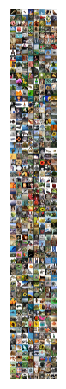

In [53]:
images, labels = next(iter(val_dataloader))
images_np = torchvision.utils.make_grid(mean.view(-1,1,1) + images * std.view(-1,1,1), nrow=20).cpu().numpy().transpose((1, 2, 0))
plt.imshow(images_np)
plt.axis('off')
plt.show()

In [54]:
img, label = next(iter(val_dataloader))
model.eval()
img = img.to(device)
output = model(img)
pred = torch.argmax(output, dim = 1)

Label: bottle


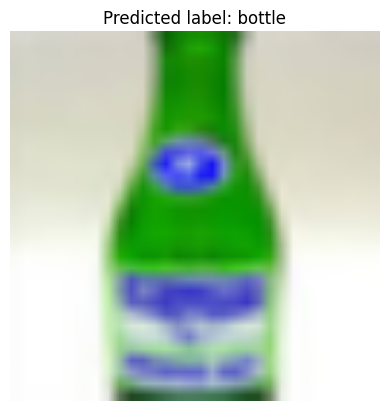

In [59]:
i = 100
img_np = (mean.view(-1,1,1) + images * std.view(-1,1,1))[i].cpu().numpy().transpose((1, 2, 0))

plt.imshow(img_np)
print(f'Original label: {classes[label[i]]}')
plt.title(f'Predicted label: {classes[pred[i]]}')
plt.axis('off')  
plt.show()

Label: caterpillar
Label: couch
Label: lizard
Label: rocket
Label: caterpillar
Label: rocket
Label: cattle
Label: caterpillar
Label: house
Label: tiger
Label: bee
Label: spider
Label: raccoon
Label: motorcycle
Label: pear
Label: chimpanzee
Label: poppy
Label: table
Label: squirrel
Label: sunflower


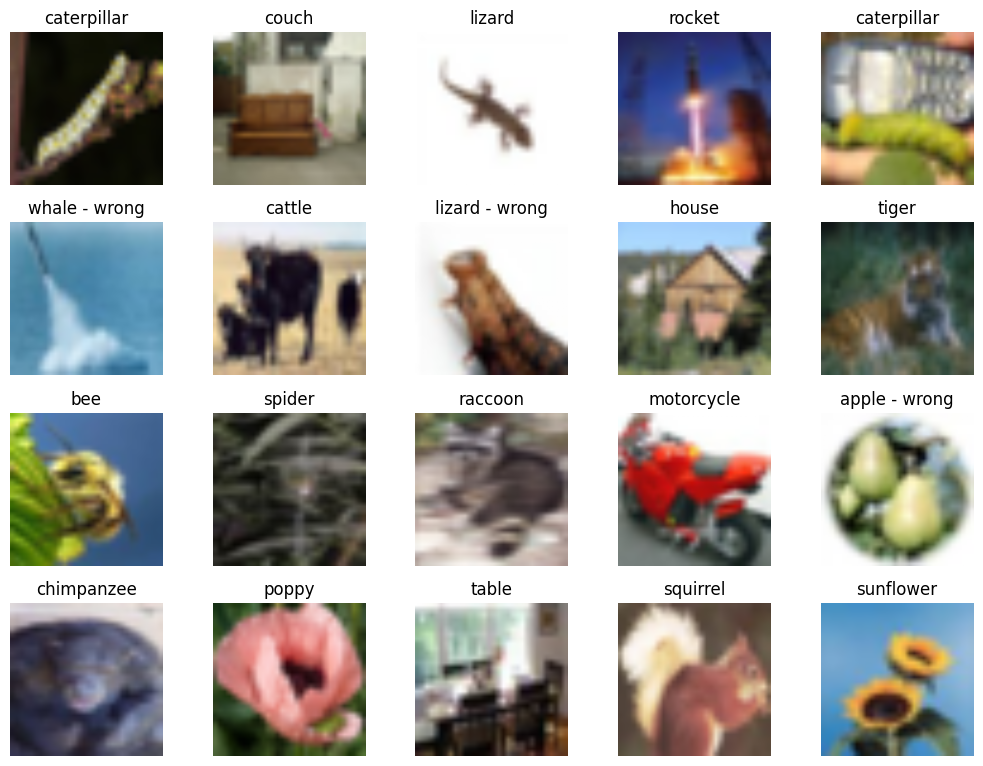

In [67]:
images, labels = next(iter(val_dataloader))
plt.figure(figsize=(10,8))
for i in range(20):
    plt.subplot(4, 5, i+1)
    plt.imshow((mean.view(-1,1,1) + images * std.view(-1,1,1))[i].cpu().numpy().transpose((1, 2, 0)))
    print(f'Label: {classes[label[i]]}')
    if classes[pred[i]] == classes[label[i]]: 
        plt.title(f'Label: {classes[labels[i]]}\nPredicted: {classes[pred[i]]}', fontsize=10)
    else:   
        plt.title(f'{classes[pred[i]]} - wrong') 
    plt.tight_layout()    
    plt.axis('off')

## Attention maps for custom model

In [ ]:
att_maps = []
for i in range(len(custom_model.blocks)):
    temp = []
    
    for j in range(custom_model.blocks[i].sa.att_weights.shape[1]):
        temp.append(custom_model.blocks[i].sa.att_weights[:, j].cpu().detach())
        
    att_maps.append(torch.stack([*temp]).squeeze(1))
att_maps = torch.stack([*att_maps], dim=0)
clf_att = att_maps[:,:, 0, 1: ]

In [ ]:
att_maps.shape

In [ ]:
attention_maps = clf_att.mean(dim=1)
attention_maps = attention_maps.view(-1, 14, 14)
plt.imshow(attention_maps[1])
attention_maps = attention_maps.unsqueeze(1)
print(attention_maps.shape)
attention_maps = F.interpolate(attention_maps, size=(224, 224), mode='bilinear', align_corners=False)
attention_maps = attention_maps.squeeze(1).mean(0)
plt.imshow(attention_maps)

In [ ]:
i = 0
plt.imshow((mean.view(-1,1,1) + images * std.view(-1,1,1))[i].cpu().numpy().transpose((1, 2, 0)))
plt.imshow(attention_maps, alpha=0.5)

In [ ]:
custom_model.blocks[0].sa.att_weights[:, 0].shape

In [ ]:
att_weights = custom_model.blocks[0].sa.att_weights.cpu().detach().mean(1)
att_weights.shape

In [ ]:
plt.imshow(att_weights[0][1:, 1:])
plt.colorbar()

In [ ]:
U, S, V = torch.linalg.svd(att_weights[0][1:, 1:])

In [ ]:
plt.plot(S)

In [ ]:
# plt.figure(figsize = (5, 3), dpi = 300)
# plt.bar(*zip(*rouge_25.items()), label = 'Full dataset, ViT decoder')
# #plt.bar(*zip(*rouge_CNN.items()), label = 'Full dataset, CNN decoder')
# plt.xticks(rotation = 90)
# plt.ylabel('ROUGE');

# plt.legend(loc = 'upper center', framealpha = 1, bbox_to_anchor = (0.5, 1.2));

# # plt.savefig('Baseline.pgf')
# # plt.savefig('Baseline.png')
# plt.savefig('ROUGE_val.png', dpi = 300)

# Parameters for model optimization quality

## Latency

In [33]:
model = PretrainedVit(num_classes=len(classes)).to(device)
model.load_state_dict(torch.load('./models/model_state.pth'))
model.eval()

PretrainedVit(
  (vit): VisionTransformer(
    (conv_proj): Conv2d(3, 768, kernel_size=(32, 32), stride=(32, 32))
    (encoder): Encoder(
      (dropout): Dropout(p=0.0, inplace=False)
      (layers): Sequential(
        (encoder_layer_0): EncoderBlock(
          (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
          (self_attention): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
          )
          (dropout): Dropout(p=0.0, inplace=False)
          (ln_2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
          (mlp): MLPBlock(
            (0): Linear(in_features=768, out_features=3072, bias=True)
            (1): GELU(approximate='none')
            (2): Dropout(p=0.0, inplace=False)
            (3): Linear(in_features=3072, out_features=768, bias=True)
            (4): Dropout(p=0.0, inplace=False)
          )
        )
        (encoder_layer_1): EncoderBlock(
          (ln_1): Lay

In [35]:
image, label = next(iter(val_dataloader))

In [36]:
num_warmup_runs = 10
for _ in range(num_warmup_runs):
    with torch.no_grad():
        _ = model(image.to(device))

In [37]:
import time

num_runs = 10  
latencies = []

with torch.no_grad():
    for _ in range(num_runs):
        start_time = time.time()
        _ = model(image.to(device))
        latency = time.time() - start_time
        latencies.append(latency)

average_latency = sum(latencies) / num_runs
print(f'Average Latency: {average_latency} seconds')

Average Latency: 0.5592600107192993 seconds


## Model size

In [40]:
model = PretrainedVit(num_classes=len(classes)).to(device)
param_size = 0
for param in model.parameters():
    param_size += param.nelement() * param.element_size()
buffer_size = 0
for buffer in model.buffers():
    buffer_size += buffer.nelement() * buffer.element_size()

size_all_mb = (param_size + buffer_size) / 1024**2
print('model size: {:.3f}MB'.format(size_all_mb))

model size: 333.909MB


# Model optimization

## Quantization

In [41]:
import torch.quantization

In [71]:
original_model = PretrainedVit(num_classes=len(classes))
quantized_model = torch.quantization.quantize_dynamic(
    original_model, {nn.Linear}, dtype=torch.qint8
)

print('Original model:')
print(original_model)
print('')
print('Quantized model:')
print(quantized_model)

Original model:
PretrainedVit(
  (vit): VisionTransformer(
    (conv_proj): Conv2d(3, 768, kernel_size=(32, 32), stride=(32, 32))
    (encoder): Encoder(
      (dropout): Dropout(p=0.0, inplace=False)
      (layers): Sequential(
        (encoder_layer_0): EncoderBlock(
          (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
          (self_attention): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
          )
          (dropout): Dropout(p=0.0, inplace=False)
          (ln_2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
          (mlp): MLPBlock(
            (0): Linear(in_features=768, out_features=3072, bias=True)
            (1): GELU(approximate='none')
            (2): Dropout(p=0.0, inplace=False)
            (3): Linear(in_features=3072, out_features=768, bias=True)
            (4): Dropout(p=0.0, inplace=False)
          )
        )
        (encoder_layer_1): EncoderBlock(
     

In [72]:
import os

def print_size_of_model(model, label=''):
    torch.save(model.state_dict(), 'temp.p')
    size=os.path.getsize('temp.p')
    print('Model: ', label, ' \t','Size (KB):', size / 1e3)
    os.remove('temp.p')
    return size

In [73]:
f=print_size_of_model(original_model, 'fp32')
q=print_size_of_model(quantized_model, 'int8')
print('{0:.2f} times smaller'.format(f/q))

model:  fp32  	 Size (KB): 350177.838


model:  int8  	 Size (KB): 180097.588
1.94 times smaller


In [75]:
input_size = (3, 224, 224) 
inputs = torch.randn(1, *input_size)

print("Floating point FP32: ")
%timeit original_model(inputs)

print("Quantized INT8: ")
%timeit quantized_model(inputs)

Floating point FP32: 


71.2 ms ± 6.92 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
Quantized INT8: 
53.5 ms ± 3.34 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [85]:
out1 = original_model(inputs)
mag1 = torch.mean(abs(out1)).item()
print('Mean absolute value of output tensor values in the FP32 model is {0:.5f} '.format(mag1))

out2 = quantized_model(inputs)
mag2 = torch.mean(abs(out2)).item()
print('Mean absolute value of output tensor values in the INT8 model is {0:.5f}'.format(mag2))

mag3 = torch.mean(abs(out1 - out2)).item()
print('Mean absolute value of the difference between the output tensors is {0:.5f} or {1:.2f} percent'.format(mag3, mag3 / mag1 * 100))

Mean absolute value of output tensor values in the FP32 model is 0.25416 
Mean absolute value of output tensor values in the INT8 model is 0.27892
Mean absolute value of the difference between the output tensors is 0.11370 or 44.73 percent


In [76]:
img, label = next(iter(val_dataloader))
original_model.eval()
quantized_model.eval()

PretrainedVit(
  (vit): VisionTransformer(
    (conv_proj): Conv2d(3, 768, kernel_size=(32, 32), stride=(32, 32))
    (encoder): Encoder(
      (dropout): Dropout(p=0.0, inplace=False)
      (layers): Sequential(
        (encoder_layer_0): EncoderBlock(
          (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
          (self_attention): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
          )
          (dropout): Dropout(p=0.0, inplace=False)
          (ln_2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
          (mlp): MLPBlock(
            (0): DynamicQuantizedLinear(in_features=768, out_features=3072, dtype=torch.qint8, qscheme=torch.per_tensor_affine)
            (1): GELU(approximate='none')
            (2): Dropout(p=0.0, inplace=False)
            (3): DynamicQuantizedLinear(in_features=3072, out_features=768, dtype=torch.qint8, qscheme=torch.per_tensor_affine)
            (4): 

In [78]:
output_orig = original_model(img)
pred_orig = torch.argmax(output_orig, dim = 1)
output_qua = quantized_model(img)
pred_qua = torch.argmax(output_qua, dim = 1)

Label: caterpillar
Label: couch
Label: lizard
Label: rocket
Label: caterpillar
Label: rocket
Label: cattle
Label: caterpillar
Label: house
Label: tiger
Label: bee
Label: spider
Label: raccoon
Label: motorcycle
Label: pear
Label: chimpanzee
Label: poppy
Label: table
Label: squirrel
Label: sunflower


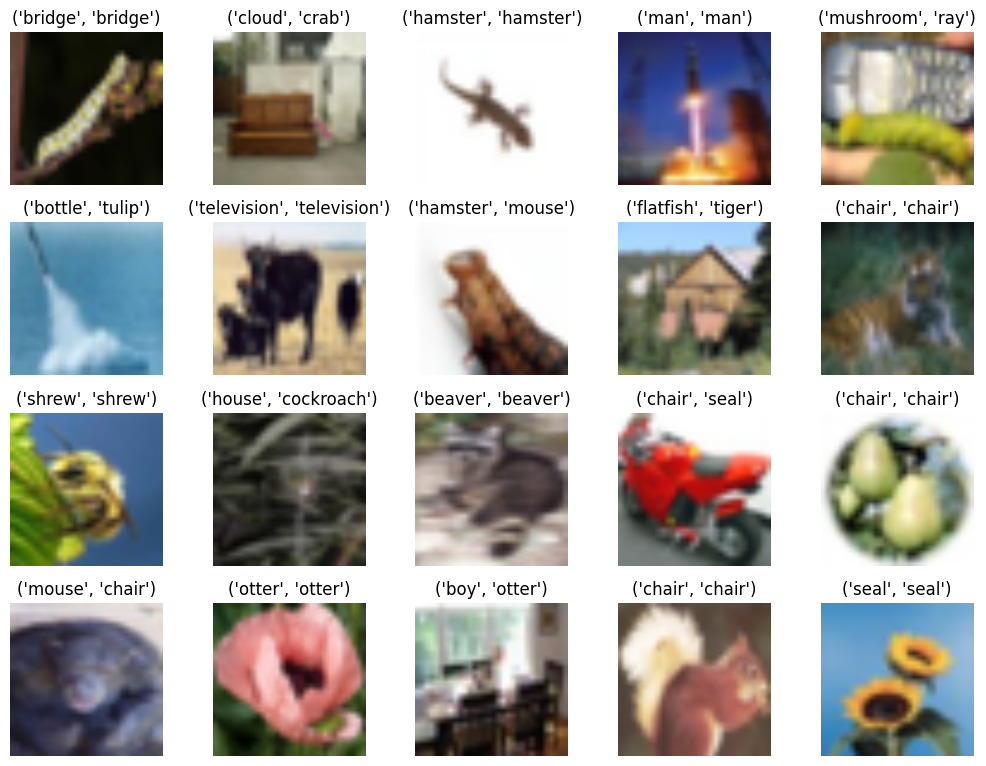

In [82]:
images, labels = next(iter(val_dataloader))
plt.figure(figsize=(10,8))
for i in range(20):
    plt.subplot(4, 5, i+1)
    plt.imshow((mean.view(-1,1,1) + images * std.view(-1,1,1))[i].cpu().numpy().transpose((1, 2, 0)))
    #print(f'Label: {classes[label[i]]}')
    plt.title(f'Label: {classes[labels[i]]}\nPredicted: {classes[pred[i]]}', fontsize=10)
    plt.tight_layout()    
    plt.axis('off')

In [ ]:
# from thop import profile
# from torchinfo import summary

# device = 'cuda' if torch.cuda.is_available() else 'cpu'

# input_size = 224

# dummy_input = torch.ones((1,3,input_size,input_size)).to(device)

# original_macs, _ = profile(original_model.vit.eval(), inputs=(dummy_input, ))
# compressed_macs, _ = profile(compressed_model.vit.eval(), inputs=(dummy_input, ))

# original_params = summary(original_model.vit.eval(), (1,3,input_size, input_size)).trainable_params
# compressed_params = summary(compressed_model.vit.eval(), (1,3,input_size, input_size)).trainable_params

# print("\n--- Original model ==> Compressed model ---")
# print(f"FLOPs: {original_macs*2} ==> {compressed_macs*2} (x{round(original_macs/compressed_macs,3)})")
# print(f"Params: {original_params} ==> {compressed_params} (x{round(original_params/compressed_params,3)})")

# Compare original & quantized models (not ready)

In [ ]:
from thop import profile
from torchinfo import summary
import time

# Evaluate model accuracy
def evaluate_accuracy(model, dataloader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in dataloader:
            outputs = model(images.to(device))
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels.to(device)).sum().item()
    accuracy = correct / total
    return accuracy

# Measure latency
def measure_latency(model, dataloader, num_runs=10):
    model.eval()
    latencies = []
    with torch.no_grad():
        for _ in range(num_runs):
            start_time = time.time()
            _ = model(next(iter(dataloader))[0].to(device))
            latency = time.time() - start_time
            latencies.append(latency)
    average_latency = sum(latencies) / num_runs
    return average_latency


def compare_models(original_model, quantized_model, dataloader):
    original_accuracy = evaluate_accuracy(original_model, dataloader)
    quantized_accuracy = evaluate_accuracy(quantized_model, dataloader)

    original_latency = measure_latency(original_model, dataloader)
    quantized_latency = measure_latency(quantized_model, dataloader)

    input_size = 224
    dummy_input = torch.ones((1, 3, input_size, input_size)).to(device)
    original_macs, _ = profile(original_model.eval(), inputs=(dummy_input,))
    quantized_macs, _ = profile(quantized_model.eval(), inputs=(dummy_input,))

    original_params = summary(original_model.eval(), (1, 3, input_size, input_size)).trainable_params
    quantized_params = summary(quantized_model.eval(), (1, 3, input_size, input_size)).trainable_params

    fig, axs = plt.subplots(2, 2, figsize=(12, 10))

    axs[0, 0].bar(['Original', 'Quantized'], [original_accuracy, quantized_accuracy])
    axs[0, 0].set_title('Accuracy')
    axs[0, 0].set_ylabel('Accuracy')

    axs[0, 1].bar(['Original', 'Quantized'], [original_latency, quantized_latency])
    axs[0, 1].set_title('Latency')
    axs[0, 1].set_ylabel('Latency (seconds)')

    axs[1, 0].bar(['Original', 'Quantized'], [original_macs, quantized_macs])
    axs[1, 0].set_title('FLOPs')
    axs[1, 0].set_ylabel('FLOPs')

    axs[1, 1].bar(['Original', 'Quantized'], [original_params, quantized_params])
    axs[1, 1].set_title('Model Parameters')
    axs[1, 1].set_ylabel('Number of Parameters')

    plt.tight_layout()
    plt.show()


original_model = PretrainedVit(num_classes=len(classes)).to(device)
original_model.load_state_dict(torch.load('./models/original_model_state.pth'))
original_model.eval()

quantized_model = PretrainedVit(num_classes=len(classes)).to(device)
quantized_model.load_state_dict(torch.load('./models/quantized_model_state.pth'))
quantized_model.eval()

compare_models(original_model, quantized_model, val_dataloader)